In [17]:
from math import pi, atan2, cos, sin, acos, asin, sqrt
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

from time import time

degToRad = pi / 180
radToDeg =  180 / pi

%matplotlib notebook
%matplotlib notebook

In [18]:
numSegments = 3

segmentLengths = np.array([1,1,1])

#upper bounds
anglesUpperBound = [pi/2, pi, pi/2, pi/2]

#lower bounds
anglesLowerBound= [-pi/2, 0, -pi/2, -pi/2]

angleWeight = 0.5
dampeningFactor = 0.5

In [19]:
armLength = segmentLengths[0]+segmentLengths[1]+segmentLengths[2]

armMinRadial = 1

In [20]:
def atTargetPosition(curPos, targetPos, distanceEpsilon=0.02):
    for i in range(len(curPos)-1):
        if( abs(curPos[i]-targetPos[i]) > distanceEpsilon):
            return False
    if i >2:
        print('Invalid Index, ', i,' - should never arrive here')
        print('curPos \n', curPos)
        return False
    
    return True

def atTargetAngle(curPos, targetPos, angleEpsilon=1*degToRad):
    if( abs(curPos[3]-targetPos[3]) > angleEpsilon):
        return False
    
    return True

def deltaPositionCartesian(curPos, targetPos):
    return curPos - targetPos

In [21]:
def flipAnglesToOuterWorkspace(angles): 
    #function flips the angles such that the new end effector is directly opposite on in the XY plane
    return np.array([angles[0] ,pi - angles[1], -angles[2], -angles[3] ])

def flipTargetIntoWorkspace(targetPos):
    #flips the target in XY plane
    return np.array([ -targetPos[0], -targetPos[1], targetPos[2], targetPos[3]])

In [22]:
def deltaPosition(curPos, targetPos):
    #delta of Position
    dPos = np.zeros(3)
    #dr
    dPos[0] = -sqrt(curPos[0]*curPos[0] + curPos[1]*curPos[1]) + sqrt(targetPos[0]*targetPos[0] + targetPos[1]*targetPos[1])
    #dz
    dPos[1] = -curPos[2] + targetPos[2]
    #dpsi - angles of gripper
    dPos[2] = -curPos[3] + targetPos[3]
    
    #weighting the distance to the target angle to de-prioritize it.
    dPos[2] *= angleWeight
    
    return dPos

In [23]:
def targetMagnitude(targetPos):
    return sqrt(targetPos[0]*targetPos[0] +targetPos[1]*targetPos[1] +  targetPos[2]*targetPos[2])

In [24]:
def forwardKinematics(angles):

    curPos = np.zeros(4)
    
    #Compute total distance to gripper
    r = (segmentLengths[0] * cos(angles[1])) + (segmentLengths[1] * cos(angles[2]+angles[1])) + (segmentLengths[2] * cos(angles[3]+angles[2]+angles[1]))

    curPos[0] = r * cos(angles[0]) #x position projection
    curPos[1] = r * sin(angles[0]) #y position projection
  
    #cylindrical height position, z
    curPos[2] = (segmentLengths[0] * sin(angles[1])) + (segmentLengths[1] * sin(angles[2]+angles[1])) + (segmentLengths[2] * sin(angles[3]+angles[2]+angles[1]))
  
    #angular position of gripper
    curPos[3] = (angles[1] + angles[2] + angles[3])
    
    return curPos

In [25]:
def getSegmentPoints(angles):
    joints = np.zeros((numSegments+1,3))
    
    #base
    joints[0,0] = 0
    joints[0,1] = 0
    joints[0,2] = 0

    r1 = (segmentLengths[0] * cos(angles[1]))
    joints[1,0] = r1 * cos(angles[0])
    joints[1,1] = r1 * sin(angles[0])
    joints[1,2] = segmentLengths[0] * sin(angles[1])

    r2 = (segmentLengths[0] * cos(angles[1])) + (segmentLengths[1] * cos(angles[2]+angles[1]))
    joints[2,0] = r2 * cos(angles[0])
    joints[2,1] = r2 * sin(angles[0])
    joints[2,2] = (segmentLengths[0] * sin(angles[1])) + (segmentLengths[1] * sin(angles[2]+angles[1]))

    r3 = (segmentLengths[0] * cos(angles[1])) + (segmentLengths[1] * cos(angles[2]+angles[1])) + (segmentLengths[2] * cos(angles[3]+angles[2]+angles[1]))
    joints[3,0] = r3 * cos(angles[0])
    joints[3,1] = r3 * sin(angles[0])
    joints[3,2] = (segmentLengths[0] * sin(angles[1])) + (segmentLengths[1] * sin(angles[2]+angles[1])) + (segmentLengths[2] * sin(angles[3]+angles[2]+angles[1]))

    return joints

In [26]:
def JacobianMatrix(angles):
    #jacobian matrix for the system derived by hand on paper, see notes
    J = np.zeros((3, 3))
    
    # compute the jacobian, r, z, psi
    J[0][0] = -segmentLengths[0]*sin(angles[1]) - segmentLengths[1]*sin(angles[1]+angles[2]) - segmentLengths[2]*sin(angles[1]+angles[2]+angles[3])
    
    J[0][1] = -segmentLengths[1]*sin(angles[1]+angles[2]) - segmentLengths[2]*sin(angles[1]+angles[2]+angles[3])
  
    J[0][2] = -segmentLengths[2]*sin(angles[1]+angles[2]+angles[3])
  
    J[1][0] = segmentLengths[0]*cos(angles[1]) + segmentLengths[1]*cos(angles[1]+angles[2]) + segmentLengths[2]*cos(angles[1]+angles[2]+angles[3])
  
    J[1][1] = segmentLengths[1]*cos(angles[1]+angles[2]) + segmentLengths[2]*cos(angles[1]+angles[2]+angles[3])
  
    J[1][2] = segmentLengths[2]*cos(angles[1]+angles[2]+angles[3])
  
    J[2][0] = 1.0
    J[2][1] = 1.0
    J[2][2] = 1.0

    return J

In [27]:
def matrix_inverse(J):  ##inverse of 3x3 matrix
    
    #TODO: Potentially perform Pseudo inverse, (J^T J)^-1 J^T to avoice singularities
    epsilon=0.0001
    
    #temporary variavle for determinant and inverse factor
    det = 0.0
    inv = 0.0
    Jinv = np.zeros((3, 3))

    det += J[0][0]*(J[1][1]*J[2][2] - J[1][2]*J[2][1])
    det -= J[0][1]*(J[1][0]*J[2][2] - J[1][2]*J[2][0])
    det += J[0][2]*(J[1][0]*J[2][1] - J[1][1]*J[2][0])
    
    if(det == 0):
        print('determinant is zero, setting to epsilon of: ', epsilon)
        det = epsilon
        
    inv = 1./det

    Jinv[0][0] =  (J[1][1]*J[2][2] - J[2][1]*J[1][2])*inv
    Jinv[0][1] = -(J[0][1]*J[2][2] - J[0][2]*J[2][1])*inv
    Jinv[0][2] =  (J[0][1]*J[1][2] - J[0][2]*J[1][1])*inv
    Jinv[1][0] = -(J[1][0]*J[2][2] - J[1][2]*J[2][0])*inv
    Jinv[1][1] =  (J[0][0]*J[2][2] - J[0][2]*J[2][0])*inv
    Jinv[1][2] = -(J[0][0]*J[1][2] - J[1][0]*J[0][2])*inv
    Jinv[2][0] =  (J[1][0]*J[2][1] - J[2][0]*J[1][1])*inv
    Jinv[2][1] = -(J[0][0]*J[2][1] - J[2][0]*J[0][1])*inv
    Jinv[2][2] =  (J[0][0]*J[1][1] - J[1][0]*J[0][1])*inv
    
    return Jinv

In [28]:
def dampedLeastSquaresMatrixIK(J, l=1):
    
    #diagonal of lambda factor
    ll = np.eye(3)*l
    
    #least squares inverse matrix 
    Jlsq = np.dot(J.T,J)+ll
    
    #invert damped matrix
    Jlsqinv = matrix_inverse(Jlsq)
    
    #get final matrix
    JJ = np.dot(Jlsqinv, J.T)    
    
    return JJ

In [29]:
def IKLeastSquares(curAngles, targetPos, dampeningFactor):

    #get current position
    curPos = forwardKinematics(curAngles)
    #get distance from target in polar system
    dPos = deltaPosition(curPos, targetPos)
    #determine the jacobian matrix
    J = JacobianMatrix(curAngles)
    #modify the jacobian with dampening
    JJ = dampedLeastSquaresMatrixIK(J, dampeningFactor)
    #get the change needed to be applied to the angles for the next iteration
    deltaAngles = np.dot(JJ, dPos)
    #print('deltaAngles \n', deltaAngles)
    #allocate new angles
    newAngles = np.array(curAngles)
   
    #print('curAngles \n', newAngles)
    #print('targetpos', targetPos)
    
    #update base angle simply
    newAngles[0] = np.arctan2(targetPos[1], targetPos[0])
    #print('after base \n', newAngles)
    #update all other angles with the change in angles
    newAngles[1:] += deltaAngles
    
    #bound checking to make sure the angles are realizable by the servo
    for i in range(len(newAngles)):
        if newAngles[i] > anglesUpperBound[i]:
            newAngles[i] = anglesUpperBound[i]
        if newAngles[i] < anglesLowerBound[i]:
            newAngles[i] = anglesLowerBound[i]
            
    #print('after delta \n', newAngles)

    return newAngles

In [30]:
def intelligentStartAngles(targetPos):
    #takes X, Y, Z target and determines the target angle to approach from based on Z height and preferred angle
    
    targetX = targetPos[0]
    targetY = targetPos[1]
    targetZ = targetPos[2]
       
    startBaseAngle = atan2(targetY, targetX)
    targetRadius = sqrt(targetY*targetY + targetX*targetX)
    startBaseElevation = atan2(targetZ, targetRadius)

    curAngles = np.array([startBaseAngle, startBaseElevation, 0., 0.])

    return curAngles

In [31]:
def intelligentTargetAngles(targetPos, direction=None):
    
    targetZ = targetPos[2]

    baseSegmentMaxHeight = segmentLengths[0]
    
    targetAngle = 0 
    
    if(direction == None):
        
        if(targetZ < baseSegmentMaxHeight*0.5):
            targetAngle = -45*degToRad
        elif(targetZ > baseSegmentMaxHeight*1.5):
            targetAngle = 45*degToRad
        else:
            targetAngle = 0
            
    return targetAngle

In [32]:
def IKLoopDebug(startAngles, targetPos, dampeningFactor, epochLimit):
    ##IK LOOP but stores all iterations and prints messages for debug
    
    jointIterations = list() # list to store what the joint locations were at each iteration
    angleIterations = list() # list to store what the servo angles were at each iteration
    
    angleIterations.append(startAngles) #append starting angles to list
    jointIterations.append(getSegmentPoints(startAngles)) #append starting joint positions to list
    
    curAngles = startAngles # initial angle
    curEpoch = 0 #epoch counter
    startTargetPos = targetPos #initial target specifications
    prevPos = np.array([99999999, 999999999, 99999999, 0]) #set previous position to "infinitely far away"
    curPos = forwardKinematics(curAngles) # get current position based on starting angles

    gotToTargetOnce = False #did i get to target immediately?
    
    atSamePlaceCount = 0 #counts how many interations you are essentially in the same place
    momentumLimit = 10 #number of iterations you can stay in same place without needing to change target angle
    
    armMaxLimitFlag = False #has the arm reached its maximum angle
    armMinLimitFlag = False #has the arm reached its minimum angle
    
    if(targetPos[0]<0):
        #target base angle can't be found using simple arctan, flip into workspace first, then solve and flip angles back at end
        print('working towards outer workspace')
        newTargetPos = flipTargetIntoWorkspace(targetPos)
        
        while((curEpoch < epochLimit) and (not atTargetPosition(curPos, targetPos)) and (not atTargetAngle(curPos, targetPos)) ):

            newAngles = IKLeastSquares(curAngles, newTargetPos, dampeningFactor)
            
            angleIterations.append(flipAnglesToOuterWorkspace(newAngles))
            jointIterations.append(getSegmentPoints(flipAnglesToOuterWorkspace(newAngles)))
            curAngles = newAngles
            curPos = forwardKinematics(curAngles)

            curEpoch += 1
            if(curEpoch > epochLimit):
                print('EPOCH LIMIT REACHED')
            
    else:  # can use arctan to find base angle
        #print('in simple workspace')
        while((curEpoch < epochLimit) and ((not atTargetPosition(curPos, targetPos)) or (not atTargetAngle(curPos, targetPos, 1*degToRad))) ):
            #while you have not reached the target position and you are not at maximum epoch limit
            
            joints = getSegmentPoints(curAngles) #get position of the joints
            #print(joints)
            
            #if you are too close to your previous position
            if( (atTargetPosition(curPos, prevPos, 0.02)) and (atTargetAngle(curPos, prevPos)) ): 
                
                #if you have been too close to previous position for too long you need to change the target angle to help reach it
                if ( atSamePlaceCount >= momentumLimit ): 
                    
                    atSamePlaceCount = 0 #reset counter
                    
                    targetRadius = sqrt(targetPos[0]*targetPos[0] + targetPos[1]*targetPos[1]) #get radius of target on XY plane

                    #can you not reach because the target angle is maxed/minned out?
                    if ( (abs(curAngles[3] - anglesUpperBound[3]) < 0.01) or (armMaxLimitFlag == True) ): #arm at max angle, reduce target angle
                        armMaxLimitFlag = True
                        print('arm at max angle, reduce target angle')
                        print("Current Joint Angles: \n", curAngles*radToDeg)
                        targetPos[3] -= 3*degToRad #decrease angle of approach so arm wont be limited
                    elif ( (abs(curAngles[3] - anglesLowerBound[3]) < 0.01) or (armMinLimitFlag == True) ): #arm at min angle, increase target angle
                        armMinLimitFlag = True
                        print('arm at min angle, increase target angle')
                        targetPos[3] += 3*degToRad #increase angle of approach so arm wont be limited
                    else:    
                        pass
                        #need to move target angle towards the angle formed from joint 2 (beginning of last segment) to target
                        # this happens when arm needs to extend further outward in order to hit target but angle of approach prevents it
                        
                        joint2Radius = sqrt(joints[2][0]*joints[2][0] + joints[2][1]*joints[2][1])
                        
                        radialDifference = targetRadius - joint2Radius
                        heightDifference = targetPos[2] - joints[2][2]
                        
                        joint2TargetAngle = atan2(heightDifference,radialDifference) 
                        
                        
                        
                        if(((newJoints[1,2] < 0) or (newJoints[2,2] < 0) or (newJoints[2,2] < 0))): #if any join position is below zero, need to decrease target angle
                            targetPos[3] -=3*degToRad
                        elif( (targetPos[2] < segmentLengths[1]) ): #target Z is low
                            targetPos[3] -=3*degToRad
                        else: # targetZ is high
                            if(joint2TargetAngle > targetPos[3]): #calculated joint 2 target angle larger than current Target angle
                                #move targetangle down
                                print('target2joint angle larger than target Angle and targetZ large, increase target angle. J2TA: ',joint2TargetAngle*radToDeg)
                                targetPos[3] += 3*degToRad
                            else:
                                #move target angle up
                                print('target2joint angle smaller than target Angle and targetZ large, decrease target angle. J2TA: ',joint2TargetAngle*radToDeg)
                                targetPos[3] -= 3*degToRad
                        
                else: ## haven't been in same place long enough to need adjustment, just increase counter
                    atSamePlaceCount += 1
                
                print('new angle case 1: arm at prev location with same place count', atSamePlaceCount)
                newAngles = IKLeastSquares(curAngles, targetPos, dampeningFactor)
            else:
                #just try to move closer
                print('new angle case 2: large movements from previous adjustment, keep going to hone in')
                newAngles = IKLeastSquares(curAngles, targetPos, dampeningFactor)
            
            
            
            #If newAngles put you in correct location but arm is below Z=0 you need to lower target angle
            newPosition = forwardKinematics(newAngles);
            newJoints = getSegmentPoints(newAngles)

            if( ((atTargetPosition(newPosition, targetPos)) and (atTargetAngle(newPosition, targetPos))) and ((newJoints[1,2] < 0) or (newJoints[2,2] < 0) or (newJoints[2,2] < 0))):
                #new position works but joints are below z=0
                print("arm below z=0, lower target angle")
                targetPos[3] -= 4*degToRad;
                #now you should not be at angle
                print("at new target angle?", atTargetAngle(newPosition, targetPos))
                
            print('Target angle is ',  targetPos[3]*radToDeg)        
            
            angleIterations.append(newAngles)
            jointIterations.append(getSegmentPoints(newAngles))
            
            prevPos = forwardKinematics(curAngles)

            curAngles = newAngles #update angles for next loop
            curPos = forwardKinematics(curAngles) #update current position for next loo[]
            
            if ((gotToTargetOnce == False) and atTargetPosition(curPos, targetPos)):
                print('At Target First Time')
                gotToTargetOnce = True
            
            #print('At Target Pos \n', atTargetPosition(curPos, targetPos))
            #print('At Target Angle \n', atTargetAngle(curPos, targetPos))
            
            curEpoch += 1
            #print('epoch: ', curEpoch)
            if(curEpoch == np.floor(epochLimit/2)):
                targetPos[3] = startTargetPos[3]*-1 #clearly something isn't working, just switch the angle of attack
            if(curEpoch > epochLimit-1):
                print('EPOCH LIMIT REACHED')
    
    return jointIterations, angleIterations, curEpoch

In [73]:
def IKSolverDebug(targetX, targetY, targetZ, targetAngle):
    
    epochLimit = 800
    
    ##Heuristics
    ##outside reach
    targetMagnitude = np.sqrt(targetX*targetX + targetY*targetY + targetZ*targetZ)
    if(targetMagnitude > armLength):
        print("Target is out of reachable area - too far")
        return False
    
    #too close to base to reach because of arm joint constraints
    if(targetMagnitude < armMinRadial):
        print ("Target is out of reachable area - too close to base")
        return False
    
    #if target height is less than first segment length you must approach at a negative angle to reach it
    if((targetZ < segmentLengths[0]) and (TargetAngle > 0)):
        print ("Target height is less than first segment length, Target Angle must be negative")
        TargetAngle = -5*degToRad #just start out at a small negative angle and find closest approach from there
        
    #if target is nearly directly above base (radial distance < sqrt(2((0.05)^2)) ) then target angle cannot be close to zero
    #otherwise gets stuck in large movement loop
    #for now starting with TargetAngle = -90 degrees is the only way i have found to fix the issue
    targetRadial = np.sqrt(targetX*targetX + targetY*targetY)
    if( (targetRadial < np.sqrt(2*((0.05)**2))) and (abs(targetAngle) < 30*degToRad)):
        print("Target is nearly directly vertical, target angle must be -90degrees or 90 degrees")
        TargetAngle = -90*degToRad
        
    targetPos = [targetX, targetY, targetZ, targetAngle]    
    
    #SOLVE for joint Angles
    #If targetX is negative you must flip target across origin into +X plane, solve for that, and then flip back across origin
    if(targetX < 0):
        print("solving flipped problem for -X plane")
        flippedFlag = True
        
        #flips the target in XY plane
        targetX = -targetX
        targetY = -targetY

        ##get Starting angles using intelligentStart
        curAngles = intelligentStartAngles([targetX, targetY, targetZ, targetAngle])
        
        startPos = forwardKinematics([curAngles[0], pi - curAngles[1], -curAngles[2], -curAngles[3]])
        
        ##Solve
        ##IKLOOP
        
        print("solving for target: \n", [targetX, targetY, targetZ], " starting from ", forwardKinematics(curAngles))
        
        jointIterations, angleIterations, curEpoch = IKLoopDebug(curAngles, [targetX, targetY, targetZ, targetAngle], dampeningFactor, epochLimit)
        
        #flip final joint angles to -X plane
        #flips the angles such that the new end effector is directly opposite on in the XY plane
        
        #flip all angle iterations
        flippedAngleIterations = list()
        for i,angles in enumerate(angleIterations):
            flippedAngleIterations.append(flipAnglesToOuterWorkspace(angles))
        
        #flip all joint iterations
        flippedJointIterations = list()
        for i,joints in enumerate(jointIterations):
            flippedJointIterations.append(getSegmentPoints(flippedAngleIterations[i]))
        
        return flippedJointIterations, flippedAngleIterations, curEpoch, flippedFlag, startPos, targetPos
    else: # do not need ot flip joint angles
        flippedFlag = False

        ##get Starting angles using intelligentStart
        curAngles = intelligentStartAngles([targetX, targetY, targetZ, targetAngle])
        startPos = forwardKinematics(curAngles)
        
        ##Solve
        ##IKLOOP
        print("solving for target: \n", [targetX, targetY, targetZ], " starting from ", forwardKinematics(curAngles))
        
        jointIterations, angleIterations, curEpoch = IKLoopDebug(curAngles, targetPos, dampeningFactor, epochLimit)
        
        return jointIterations, angleIterations, curEpoch, flippedFlag,  startPos, targetPos

In [74]:
#define target
targetX = 2
targetY = 0
targetZ = 0.5
targetAng = -90*degToRad

targetPos = np.array([targetX, targetY, targetZ,targetAng])
#targetPos = np.array([targetX, targetY, targetZ, intelligentTargetAngles(targetPos, direction=None)])

#define starting angles/position
curAngles = intelligentStartAngles(targetPos)
#curAngles = np.array([0.,0,0.,0.]) #set start angles
startPos = forwardKinematics(curAngles) #set startPosition

epochLimit = 3000 #set iteration limit

print("Current Joint Angles: \n", curAngles*radToDeg)
curPos = forwardKinematics(curAngles)
startPos = np.array(curPos)
print("Current Position: \n",  curPos[:3], 'with angle ',  curPos[3]*radToDeg, ' degrees')
print("Target Position: \n", targetPos[:3], 'with angle ',  targetPos[3]*radToDeg, ' degrees')
print("Target Mangitude: ",  targetMagnitude(targetPos))

t0 = time()

jointIterations, angleIterations, totalEpochs = IKLoopDebug(curAngles, targetPos, dampeningFactor, epochLimit)
t1 = time()

jointIterations= np.array(jointIterations)
curPos = forwardKinematics(angleIterations[-1])
print('total time \n', t1-t0)
print("final join positions",  jointIterations[-1])
print('Final Joint Angles \n', angleIterations[-1]*radToDeg, ' degrees')
print('Final Position \n', curPos[:3], 'with angle ',  curPos[3]*radToDeg, ' degrees')
print('Final Delta Position \n', deltaPositionCartesian(forwardKinematics(angleIterations[-1]), targetPos))
print('Epochs Required: ', totalEpochs)

Current Joint Angles: 
 [  0.          14.03624347   0.           0.        ]
Current Position: 
 [ 2.9104275   0.          0.72760688] with angle  14.0362434679  degrees
Target Position: 
 [ 2.   0.   0.5] with angle  -90.0  degrees
Target Mangitude:  2.0615528128088303
new angle case 2: large movements from previous adjustment, keep going to hone in
Target angle is  -90.0
new angle case 2: large movements from previous adjustment, keep going to hone in
Target angle is  -90.0
new angle case 2: large movements from previous adjustment, keep going to hone in
Target angle is  -90.0
new angle case 2: large movements from previous adjustment, keep going to hone in
Target angle is  -90.0
new angle case 2: large movements from previous adjustment, keep going to hone in
Target angle is  -90.0
new angle case 2: large movements from previous adjustment, keep going to hone in
Target angle is  -90.0
new angle case 1: arm at prev location with same place count 1
Target angle is  -90.0
new angle ca

In [75]:
#define target
targetX = 1
targetY = 1.5
targetZ = 0.5
targetAng = -90*degToRad

t0 = time()
jointIterations, angleIterations, totalEpochs, flippedFlag, startPos, targetPos = IKSolverDebug(targetX, targetY, targetZ, targetAng)
t1 = time()

jointIterations= np.array(jointIterations)
curPos = forwardKinematics(angleIterations[-1])

print("\n \n")
print("!@#$!@#$!@#$!@#$!@#$!@#$!@#$!@#$")
print('total time \n', round(t1-t0,3), "seconds \n")
print("final joint positions \n",  jointIterations[-1], "\n")
print('Final Joint Angles \n', angleIterations[-1]*radToDeg, ' degrees \n')
print('Final Position \n', curPos[:3], 'with angle ',  curPos[3]*radToDeg, ' degrees \n')
print('Final Delta Position \n', deltaPositionCartesian(forwardKinematics(angleIterations[-1]), targetPos), "\n")
print('Epochs Required: ', totalEpochs, "\n")


UnboundLocalError: local variable 'TargetAngle' referenced before assignment

<IPython.core.display.Javascript object>


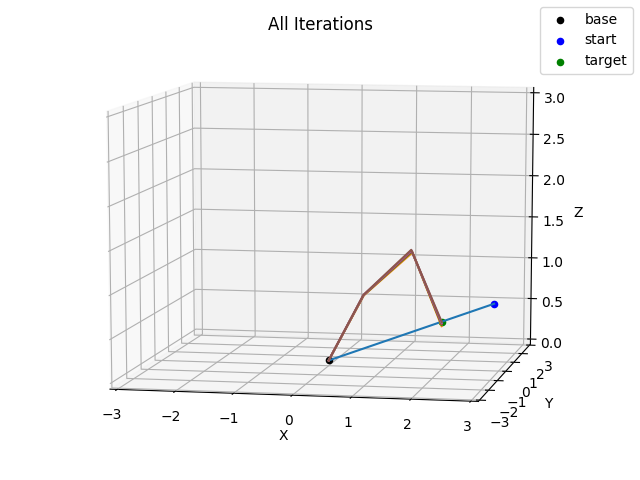

In [76]:
showEveryN = 1

if totalEpochs > 100:
    showEveryN = int(totalEpochs/5)

if totalEpochs > 1000:
    showEveryN = int(totalEpochs/50)
    
showEveryN

# Attaching 3D axis to the figure
fig = plt.figure()
ax = Axes3D(fig)

# Plot all iterations at once
# NOTE: Can't pass empty arrays into 3d version of plot()

jointIterationsPlot = np.array(jointIterations[::showEveryN,:,:])

line = [ax.plot(jointIterationsPlot[i,:,0], jointIterationsPlot[i,:,1], jointIterationsPlot[i,:,2]) for i in range(jointIterationsPlot.shape[0])]


# Setting the axes propertiesss
ax.set_xlim3d([-3, 3])
ax.set_xlabel('X')

ax.set_ylim3d([-3, 3])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, 3])
ax.set_zlabel('Z')

ax.set_title('All Iterations')

ax.scatter(0,0,0, c='k', label='base')
ax.scatter(startPos[0],startPos[1],startPos[2], c='b', label='start')
ax.scatter(targetPos[0],targetPos[1],targetPos[2], c='g', label='target')
    
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


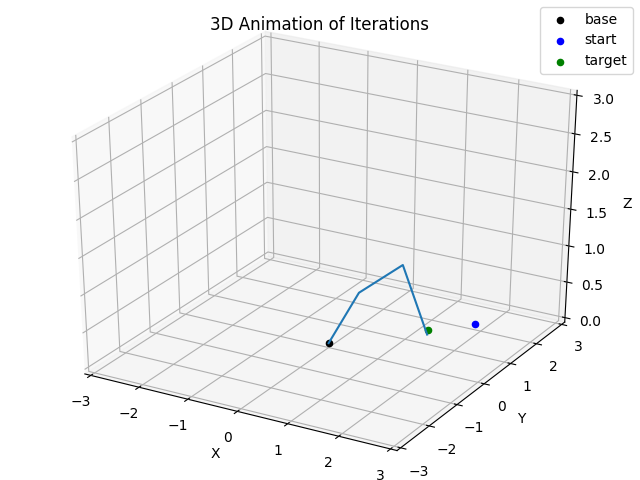

In [82]:
"""
============
3D animation
============

A simple example of an animated plot... In 3D!
"""
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

def update_lines(num, dataLines, line):
    if(num >= dataLines.shape[0]):
        return
    line.set_data(dataLines[num,:,0],dataLines[num,:,1])
    line.set_3d_properties(dataLines[num,:,2])
    return line

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

# Iteration Data
showEveryN = 1

dataLines = np.array(jointIterations[::showEveryN])
#dataLines = [ [jointIterations[i,:,0], jointIterations[i,:,1], jointIterations[i,:,2]] for i in range(jointIterations.shape[0])]

#showUpTo = dataLines.shape[0]+5
showUpTo = 30


# Creating fifty line objects.
# NOTE: Can't pass empty arrays into 3d version of plot()
line = ax.plot(dataLines[0,:,0], dataLines[0,:,1], dataLines[0,:,2])[0] ## must index by zero because ax.plot returns list of artists

# Setting the axes properties
ax.set_xlim3d([-3.0, 3.0])
ax.set_xlabel('X')

ax.set_ylim3d([-3.0, 3.0])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, 3.0])
ax.set_zlabel('Z')


ax.set_title('3D Animation of Iterations')

# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, showUpTo, fargs=(dataLines, line),interval=200, blit=False)

line_ani.save('robo2.mp4', writer=writer)

ax.scatter(0,0,0, c='k', label='base')
ax.scatter(startPos[0],startPos[1],startPos[2], c='b', label='start')
ax.scatter(targetPos[0],targetPos[1],targetPos[2], c='g', label='target')
ax.legend()
plt.show()

## Known Issues

1) Target x=1, y=-1, z=1, theta = 90deg hits epoch limit

2) targetX = .0, targetY = -0., targetZ = 1, targetAng = -0*degToRad hits epoch limit

3) If targetX=targetY=0 arm always solves learning on -X plane, find way to specify to lean on +X plane, -Y plane, and +Y plane

4) If TargetX=1, targetY=TargetZ=0 (minimal grab distance) and targetAngle =0 it loops around angles 0-180, then 180-320 before hitting half-epochLimit and going -320 down to the solve angle of -90. Add heuristic to make it flip angle apporach ones it its 90/-90  
4.1) very close radial distances do not function with many target angles, gets stuck in large movement loop. Need to find better way to approach small radial distances

5) TargetX=targetY=0, targetZ>2.95 (near maxArmLength) with targetAngles <=78 causes large movement loop and epoch limit failure

6) cannot target 90 degree angle if magnitude distance is too close (potentially anything closer than segmentLength1+segmentLength2?)

## To Do:

1) add base Z offset for real arm, updating forward kinematics and joint calculations as needed

2) measure arm and use real length for each segment

3) Add heuristics to override target angles that are not reasonable
 * Target positions with radius < 1 should be negative angles
 * Target Position with magnitude > 3 are thrown out
 * Target positions with radius = 1 and z=0 must have angle -90 deg

# Barebones Solver
### No debug messages

In [60]:
def IKLoop(startAngles, targetPos, dampeningFactor, epochLimit):
    #does not store iterations, for speed
    
    curAngles = startAngles # initial angle
    curEpoch = 0 #epoch counter
    startTargetPos = targetPos #initial target specifications
    prevPos = np.array([99999999, 999999999, 99999999, 0]) #set previous position to "infinitely far away"
    curPos = forwardKinematics(curAngles) # get current position based on starting angles

    gotToTargetOnce = False #did i get to target immediately?
    
    atSamePlaceCount = 0 #counts how many interations you are essentially in the same place
    momentumLimit = 10 #number of iterations you can stay in same place without needing to change target angle
    
    armMaxLimitFlag = False #has the arm reached its maximum angle
    armMinLimitFlag = False #has the arm reached its minimum angle

    while((curEpoch < epochLimit) and ((not atTargetPosition(curPos, targetPos)) or (not atTargetAngle(curPos, targetPos, 1*degToRad))) ):
        #while you have not reached the target position and you are not at maximum epoch limit

        joints = getSegmentPoints(curAngles) #get position of the joints
        #print(joints)

        #if you are too close to your previous position
        if( (atTargetPosition(curPos, prevPos, 0.02)) and (atTargetAngle(curPos, prevPos)) ): 

            #if you have been too close to previous position for too long you need to change the target angle to help reach it
            if ( atSamePlaceCount >= momentumLimit ): 

                atSamePlaceCount = 0 #reset counter

                targetRadius = sqrt(targetPos[0]*targetPos[0] + targetPos[1]*targetPos[1]) #get radius of target on XY plane

                #can you not reach because the target angle is maxed/minned out?
                if ( (abs(curAngles[3] - anglesUpperBound[3]) < 0.01) or (armMaxLimitFlag == True) ): #arm at max angle, reduce target angle
                    armMaxLimitFlag = True
                    #print('arm at max angle, reduce target angle')
                    targetPos[3] -= 3*degToRad #decrease angle of approach so arm wont be limited
                elif ( (abs(curAngles[3] - anglesLowerBound[3]) < 0.01) or (armMinLimitFlag == True) ): #arm at min angle, increase target angle
                    armMinLimitFlag = True
                    #print('arm at min angle, increase target angle')
                    targetPos[3] += 3*degToRad #increase angle of approach so arm wont be limited
                else:    
                    pass
                    #need to move target angle towards the angle formed from joint 2 (beginning of last segment) to target
                    # this happens when arm needs to extend further outward in order to hit target but angle of approach prevents it

                    joint2Radius = sqrt(joints[2][0]*joints[2][0] + joints[2][1]*joints[2][1])

                    radialDifference = targetRadius - joint2Radius
                    heightDifference = targetPos[2] - joints[2][2]

                    joint2TargetAngle = atan2(heightDifference,radialDifference) 

                    if(((newJoints[1,2] < 0) or (newJoints[2,2] < 0) or (newJoints[2,2] < 0))): #if any join position is below zero, need to decrease target angle
                        targetPos[3] -=3*degToRad
                    elif( (targetPos[2] < segmentLengths[1]) ): #target Z is low
                        targetPos[3] -=3*degToRad
                    else: # targetZ is high
                        if(joint2TargetAngle > targetPos[3]): #calculated joint 2 target angle larger than current Target angle
                            #move targetangle down
                            #print('target2joint angle larger than target Angle and targetZ large, increase target angle. J2TA: ',joint2TargetAngle*radToDeg)
                            targetPos[3] += 3*degToRad
                        else:
                            #move target angle up
                            #print('target2joint angle smaller than target Angle and targetZ large, decrease target angle. J2TA: ',joint2TargetAngle*radToDeg)
                            targetPos[3] -= 3*degToRad

            else: ## haven't been in same place long enough to need adjustment, just increase counter
                atSamePlaceCount += 1

            #print('new angle case 1: arm at prev location with same place count', atSamePlaceCount)
            newAngles = IKLeastSquares(curAngles, targetPos, dampeningFactor)
        else:
            #just try to move closer
            #print('new angle case 2: large movements from previous adjustment, keep going to hone in')
            newAngles = IKLeastSquares(curAngles, targetPos, dampeningFactor)

        #If newAngles put you in correct location but arm is below Z=0 you need to lower target angle
        newPosition = forwardKinematics(newAngles);
        newJoints = getSegmentPoints(newAngles)

        if( ((atTargetPosition(newPosition, targetPos)) and (atTargetAngle(newPosition, targetPos))) and ((newJoints[1,2] < 0) or (newJoints[2,2] < 0) or (newJoints[2,2] < 0))):
            #new position works but joints are below z=0
            #print("arm below z=0, lower target angle")
            targetPos[3] -= 4*degToRad;
            #now you should not be at angle
            #print("at new target angle?", atTargetAngle(newPosition, targetPos))
            
            #print('Target angle is ',  targetPos[3]*radToDeg)        
                        
        prevPos = forwardKinematics(curAngles)

        curAngles = newAngles #update angles for next loop
        curPos = forwardKinematics(curAngles) #update current position for next loo[]

        if ((gotToTargetOnce == False) and atTargetPosition(curPos, targetPos)):
            #print('At Target First Time')
            gotToTargetOnce = True

        #print('At Target Pos \n', atTargetPosition(curPos, targetPos))
        #print('At Target Angle \n', atTargetAngle(curPos, targetPos))

        curEpoch += 1
        #print('epoch: ', curEpoch)
        if(curEpoch == np.floor(epochLimit/2)):
            targetPos[3] = startTargetPos[3]*-1 #clearly something isn't working, just switch the angle of attack
        if(curEpoch > epochLimit-1):
            print('EPOCH LIMIT REACHED')
    
    return curAngles

In [61]:
def IKSolver(targetX, targetY, targetZ, targetAngle):
    
    epochLimit = 800
    
    ##Heuristics
    ##outside reach
    targetMagnitude = np.sqrt(targetX*targetX + targetY*targetY + targetZ*targetZ)
    if(targetMagnitude > armLength):
        print("Target is out of reachable area - too far")
        return False
    
    #too close to base to reach because of arm joint constraints
    if(targetMagnitude < armMinRadial):
        print ("Target is out of reachable area - too close to base")
        return False
    
    #if target height is less than first segment length you must approach at a negative angle to reach it
    if((targetZ < segmentLengths[0]) and (TargetAngle > 0)):
        TargetAngle = -5*degToRad #just start out at a small negative angle and find closest approach from there
        
    #if target is nearly directly above base (radial distance < sqrt(2((0.05)^2)) ) then target angle cannot be close to zero
    #otherwise gets stuck in large movement loop
    #for now starting with TargetAngle = -90 degrees is the only way i have found to fix the issue
    targetRadial = np.sqrt(targetX*targetX + targetY*targetY)
    if( (targetRadial < np.sqrt(2*((0.05)**2))) and (abs(targetAngle) < 30*degToRad)):
        TargetAngle = -90*degToRad
        
        
    #SOLVE for joint Angles
    #If targetX is negative you must flip target across origin into +X plane, solve for that, and then flip back across origin
    if(targetX < 0):
        #flips the target in XY plane
        targetX = -targetX
        targetY = -targetY
        
        ##get Starting angles using intelligentStart
        curAngles = intelligentStartAngles([targetX, targetY, targetZ, targetAngle])
        
        ##Solve
        ##IKLOOP
        jointAngles = IKLoop(curAngles, targetPos, dampeningFactor, epochLimit)
        
        #flip final joint angles to -X plane
        #flips the angles such that the new end effector is directly opposite on in the XY plane
        jointangles[1] = pi - jointangles[1]
        jointangles[2] = -1*jointangles[2]
        jointangles[3] = -1*jointangles[3]
        
        return jointAngles
    else: # do not need ot flip joint angles
        
        ##get Starting angles using intelligentStart
        curAngles = intelligentStartAngles([targetX, targetY, targetZ, targetAngle])
        
        ##Solve
        ##IKLOOP
        jointAngles = IKLoop(curAngles, targetPos, dampeningFactor, epochLimit)
        
        return jointAngles

In [62]:
jointAngles = IKSolver(2, 0 , 1, 0*degToRad)


EPOCH LIMIT REACHED
